# Love Problems or Law Problems?

## Table of Contents:
### [Reading In Data](#r/legaladvice-and-r/relationships)
### [Model 1: Logistic Regression](#Logistic-Regression)
### [Model 2: Multinomial Naive Bayes](#Multinomial-Naive-Bayes)
### [Findings](#Conclusion)

## Imports

In [1]:
import pandas as pd

import nltk
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.metrics import confusion_matrix

from IPython.display import display, Markdown
import matplotlib.pyplot as plt

%%matplotlib inline

## Library

In [2]:
def get_info(df):
    """
    Prints some EDA-like information about the given dataframe.
    """
    print('Number of empty posts:', df['selftext'].isnull().sum())
    print('Number of unique authors:', df['author'].nunique())
    print('Most popular posts:')
    display(df.sort_values('score', ascending=False).head(3))
    print('Most discussed posts:')
    display(df.sort_values('num_comments', ascending=False).head(3))

In [3]:
def clean_post(post):
    """
    Does basic cleaning of the text. Removes non-alphabetical characters and transforms to lowercase.
    """
    return " ".join(re.sub("[^a-zA-Z]", " ", str(post)).lower().split())

In [4]:
def performance_metrics(y_test, preds):
    """
    Takes in actual y-values and predicted y-values and prints out two Markdown tables:
    a formatted confusion matrix; and a table of five computed classification metrics.
    """
    display(Markdown('#### Confusion Matrix'))
    display(pd.DataFrame(confusion_matrix(y_test, preds), columns=['predicted relationship', 'predicted legal'],
            index=['actual relationship', 'actual legal']))
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    accuracy = round(((tn + tp) / (tn + tp + fn + fp)), 3)
    
    precision = round((tp / (tp + fp)), 3)
    
    sensitivity = round((tp / (tp + fn)), 3)
    
    specificity = round((tn / (tn + fp)), 3)
    
    misclassification_rate = round(((fp + fn) / (tn + tp + fn + fp)), 3)
    
    performance = f"""| Metric  | Score
|--------|--------------------
| Accuracy | {accuracy} |
| Precision | {precision} |
| Sensitivity | {sensitivity} |
| Specificity | {specificity} |
| Misclassification Rate | {misclassification_rate} |"""
    
    display(Markdown('#### Performance Metrics'))
    display(Markdown(performance))

In [5]:
def gs_pipe_performance(gspipe, X_train, X_test, y_train, y_test):
    """
    Prints out a number of informative messages about a GridSearchCV object after it has been fit.
    Includes: best score, best params (for the best estimator), training and test scores, the scorer,
    the baseline (i.e., normalized actual y-value counts), and also calls performance_metrics().
    """
    print("Best score:", gspipe.best_score_)
    print()
    print("Best params:")
    for k, v in gspipe.best_params_.items():
        print("\t"+k, v)
        print()
    print()
    print("Training score:", gspipe.score(X_train, y_train))
    print("Test score:", gspipe.score(X_test, y_test))
    print("Scorer:", gspipe.scorer_)
    print()
    print("Baseline:")
    print(y_test.value_counts(normalize=True))
    print()
    preds = gspipe.predict(X_test)
    print(preds[:20])
    performance_metrics(y_test, preds)

## r/legaladvice and r/relationships

[**return to top of notebook**](#Love-Problems-or-Law-Problems?)

### r/legaladvice

In [6]:
legaladvice = pd.read_csv('./datasets/r_legaladvice.csv')
print(legaladvice.shape)
print()
for c in legaladvice.columns:
    print(c, legaladvice[c].dtype)
print(legaladvice.isnull().sum())
legaladvice.head()

(2503, 14)

author object
author_fullname object
created_utc int64
domain object
full_link object
id object
num_comments int64
permalink object
score int64
selftext object
subreddit object
subreddit_id object
title object
url object
author              0
author_fullname     0
created_utc         0
domain              0
full_link           0
id                  0
num_comments        0
permalink           0
score               0
selftext           32
subreddit           0
subreddit_id        0
title               0
url                 0
dtype: int64


,author,author_fullname,created_utc,domain,full_link,id,num_comments,permalink,score,selftext,subreddit,subreddit_id,title,url
0,SpookWithoutaName,t2_4j8ld79a,1570821844,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,dgjxs9,109,/r/legaladvice/comments/dgjxs9/my_identity_was...,179,Most people think my username is an attempt to...,legaladvice,t5_2rawz,My identity was erased. How do I get it back?,https://www.reddit.com/r/legaladvice/comments/...
1,Crockett721,t2_7gc0b,1570731602,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,dg240u,147,/r/legaladvice/comments/dg240u/i_purchased_a_v...,9381,A bit of a doozy...\n\nI purchased a car Satur...,legaladvice,t5_2rawz,I purchased a vehicle and was assaulted by the...,https://www.reddit.com/r/legaladvice/comments/...
2,Alex6095,t2_th4igev,1570735501,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,dg33fj,45,/r/legaladvice/comments/dg33fj/made_an_osha_co...,505,"Hi, I work in a factory that produces products...",legaladvice,t5_2rawz,Made an OSHA complaint about hazardous working...,https://www.reddit.com/r/legaladvice/comments/...
3,TNInsuranceTicket,t2_4rqc7l9v,1570736500,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,dg3cij,54,/r/legaladvice/comments/dg3cij/tn_police_offic...,185,I'll do my best to keep this brief. I was pull...,legaladvice,t5_2rawz,[TN] Police Officer wouldn't accept my insuran...,https://www.reddit.com/r/legaladvice/comments/...
4,roastedmarshmellow86,t2_z3xnx,1570795592,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,dge74l,158,/r/legaladvice/comments/dge74l/my_gm_is_strong...,3167,Some history:\n I was hired here by 2 of the D...,legaladvice,t5_2rawz,My GM is strongly implying ill be Terminated o...,https://www.reddit.com/r/legaladvice/comments/...


In [7]:
get_info(legaladvice)

Number of empty posts: 32
Number of unique authors: 2395
Most popular posts:


,author,author_fullname,created_utc,domain,full_link,id,num_comments,permalink,score,selftext,subreddit,subreddit_id,title,url
1702,poksoooosoo28,t2_3jaicttf,1556209785,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,bhaof3,4,/r/legaladvice/comments/bhaof3/update_neighbor...,55763,Original post: https://www.reddit.com/r/legala...,legaladvice,t5_2rawz,(Update) Neighbors child has disabilities and ...,https://www.reddit.com/r/legaladvice/comments/...
1653,throwaway_18701,t2_3dma3xwj,1556477313,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,bieir5,3,/r/legaladvice/comments/bieir5/update_pa_i_fol...,38858,This is an update to my [original post](https:...,legaladvice,t5_2rawz,[UPDATE] [PA] I followed and reported a drunk ...,https://www.reddit.com/r/legaladvice/comments/...
1760,throwmeinalake123,t2_3gba89ml,1555643214,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,beuf9y,4,/r/legaladvice/comments/beuf9y/update_my_fathe...,35337,[Here's my original post](https://www.reddit.c...,legaladvice,t5_2rawz,"UPDATE: My father and step mother died, leavin...",https://www.reddit.com/r/legaladvice/comments/...


Most discussed posts:


,author,author_fullname,created_utc,domain,full_link,id,num_comments,permalink,score,selftext,subreddit,subreddit_id,title,url
2314,Zanctmao,t2_nszex,1551735326,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,axcpzw,599,/r/legaladvice/comments/axcpzw/megathread_it_w...,905,This was initially discussed in [this megathre...,legaladvice,t5_2rawz,[Megathread] It will become a federal crime to...,https://www.reddit.com/r/legaladvice/comments/...
1328,GoonDaFirst,t2_zmh7d,1558893052,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,btauw7,390,/r/legaladvice/comments/btauw7/mi_usa_consider...,9511,"I have a big family, with around 20 cousins, ...",legaladvice,t5_2rawz,"[MI, USA] Considering suing my uncle after he ...",https://www.reddit.com/r/legaladvice/comments/...
1927,poksoooosoo28,t2_3jaicttf,1554323940,self.legaladvice,https://www.reddit.com/r/legaladvice/comments/...,b93dx3,353,/r/legaladvice/comments/b93dx3/neighbors_child...,18239,For the past 7 months after moving in to my ne...,legaladvice,t5_2rawz,Neighbors child has disabilities and won't sto...,https://www.reddit.com/r/legaladvice/comments/...


In [8]:
legaladvice.dropna(inplace=True)

In [9]:
legaladvice.shape

(2471, 14)

In [10]:
legaladvice.columns

Index(['author', 'author_fullname', 'created_utc', 'domain', 'full_link', 'id',
       'num_comments', 'permalink', 'score', 'selftext', 'subreddit',
       'subreddit_id', 'title', 'url'],
      dtype='object')

In [11]:
legaladvice['op_text'] = legaladvice['title'] + " " + legaladvice['selftext']
legal_input = legaladvice[['op_text']].copy()
legal_input['is_legal'] = 1
legal_input.head()

,op_text,is_legal
0,My identity was erased. How do I get it back? ...,1
1,I purchased a vehicle and was assaulted by the...,1
2,Made an OSHA complaint about hazardous working...,1
3,[TN] Police Officer wouldn't accept my insuran...,1
4,My GM is strongly implying ill be Terminated o...,1


### r/relationships

In [12]:
relationships = pd.read_csv('./datasets/r_relationships.csv')
print(relationships.shape)
print()
for c in relationships.columns:
    print(c, relationships[c].dtype)
print(relationships.isnull().sum())
relationships.head()

(2508, 14)

author object
author_fullname object
created_utc int64
domain object
full_link object
id object
num_comments int64
permalink object
score int64
selftext object
subreddit object
subreddit_id object
title object
url object
author             0
author_fullname    0
created_utc        0
domain             0
full_link          0
id                 0
num_comments       0
permalink          0
score              0
selftext           0
subreddit          0
subreddit_id       0
title              0
url                0
dtype: int64


,author,author_fullname,created_utc,domain,full_link,id,num_comments,permalink,score,selftext,subreddit,subreddit_id,title,url
0,Weak_Business,t2_4rhiezyx,1570651879,self.relationships,https://www.reddit.com/r/relationships/comment...,dfmmwc,691,/r/relationships/comments/dfmmwc/i_am_26f_7_mo...,2446,I don't even know how to start this post. I wa...,relationships,t5_2qjvn,I am (26f) 7 months pregnant with a married ma...,https://www.reddit.com/r/relationships/comment...
1,beetsgonewilde,t2_4ri3dgnj,1570656336,self.relationships,https://www.reddit.com/r/relationships/comment...,dfnooe,143,/r/relationships/comments/dfnooe/should_i_25f_...,907,I was with my boyfriend Nate for about a year....,relationships,t5_2qjvn,Should I (25F) cut off all my friends (25-27MF...,https://www.reddit.com/r/relationships/comment...
2,throwaway080519670,t2_3ix72rv6,1570656793,self.relationships,https://www.reddit.com/r/relationships/comment...,dfnshq,134,/r/relationships/comments/dfnshq/am_i_20f_over...,183,I am using a throwaway because my boyfriend (2...,relationships,t5_2qjvn,Am I (20F) overreacting or was this joke insen...,https://www.reddit.com/r/relationships/comment...
3,bitterbuffalohearts,t2_3ml503vf,1570662311,self.relationships,https://www.reddit.com/r/relationships/comment...,dfp26n,141,/r/relationships/comments/dfp26n/my_f29_husban...,299,My husband cannot handle being asked to do som...,relationships,t5_2qjvn,My [F29] husband of nine years [M36] cannot ha...,https://www.reddit.com/r/relationships/comment...
4,Queen_Of_Ashes_,t2_3sy62flb,1570695815,self.relationships,https://www.reddit.com/r/relationships/comment...,dfuy2g,531,/r/relationships/comments/dfuy2g/update_i_28f_...,5906,Previous post can be found [here](https://www....,relationships,t5_2qjvn,UPDATE: I (28F) am getting tired of my bf (28M...,https://www.reddit.com/r/relationships/comment...


In [13]:
get_info(relationships)

Number of empty posts: 0
Number of unique authors: 2453
Most popular posts:


,author,author_fullname,created_utc,domain,full_link,id,num_comments,permalink,score,selftext,subreddit,subreddit_id,title,url
2234,LadyGrey90,t2_10tayt,1555589790,self.relationships,https://www.reddit.com/r/relationships/comment...,beku6e,760,/r/relationships/comments/beku6e/update_my_28f...,9726,[Original post](https://www.reddit.com/r/relat...,relationships,t5_2qjvn,[UPDATE] My (28F) colleague (30F) didn't invit...,https://www.reddit.com/r/relationships/comment...
480,Gerrrrtty,t2_4bd4qle8,1567170329,self.relationships,https://www.reddit.com/r/relationships/comment...,cxgnob,185,/r/relationships/comments/cxgnob/my_30f_husban...,8758,Update to https://www.reddit.com/r/relationshi...,relationships,t5_2qjvn,My (30F) husband (32M) impulse bought a dog. [...,https://www.reddit.com/r/relationships/comment...
726,big_platypus_,t2_39rxxrpc,1565219527,self.relationships,https://www.reddit.com/r/relationships/comment...,cnd80k,538,/r/relationships/comments/cnd80k/update_my_24_...,8107,Link to original post [https://www.reddit.com/...,relationships,t5_2qjvn,UPDATE: My [24 F] boyfriend [26 M] of 6 months...,https://www.reddit.com/r/relationships/comment...


Most discussed posts:


,author,author_fullname,created_utc,domain,full_link,id,num_comments,permalink,score,selftext,subreddit,subreddit_id,title,url
1934,Bee5431,t2_3h02g4j0,1557250985,self.relationships,https://www.reddit.com/r/relationships/comment...,bltp4x,1166,/r/relationships/comments/bltp4x/im_ready_to_l...,5409,I (31F) am so overwhelmed and literally about ...,relationships,t5_2qjvn,I'm ready to leave my (31F) husband (30M) over...,https://www.reddit.com/r/relationships/comment...
1419,unbeliavable211,t2_3y6jvse9,1560597460,self.relationships,https://www.reddit.com/r/relationships/comment...,c0w90i,1092,/r/relationships/comments/c0w90i/partner29m_sa...,3884,We've been together for 5 years and in the las...,relationships,t5_2qjvn,Partner[29M] says he will divorce me [26F] if ...,https://www.reddit.com/r/relationships/comment...
1554,SweetButteryStacks,t2_3tux27b2,1559743398,self.relationships,https://www.reddit.com/r/relationships/comment...,bx2x4a,1077,/r/relationships/comments/bx2x4a/i_29f_think_i...,3574,My bf and I have been together for 8 years. Du...,relationships,t5_2qjvn,I [29/F] think I need to leave my bf[31/M] of ...,https://www.reddit.com/r/relationships/comment...


In [14]:
relationships.shape

(2508, 14)

In [15]:
relationships.columns

Index(['author', 'author_fullname', 'created_utc', 'domain', 'full_link', 'id',
       'num_comments', 'permalink', 'score', 'selftext', 'subreddit',
       'subreddit_id', 'title', 'url'],
      dtype='object')

In [16]:
relationships['op_text'] = relationships['title'] + " " + relationships['selftext']
relationship_input = relationships[['op_text']].copy()
relationship_input['is_legal'] = 0
relationship_input.head()

,op_text,is_legal
0,I am (26f) 7 months pregnant with a married ma...,0
1,Should I (25F) cut off all my friends (25-27MF...,0
2,Am I (20F) overreacting or was this joke insen...,0
3,My [F29] husband of nine years [M36] cannot ha...,0
4,UPDATE: I (28F) am getting tired of my bf (28M...,0


## Joining

### making them the same shape

In [17]:
legal_input.shape

(2471, 2)

In [18]:
relationship_input.shape

(2508, 2)

In [19]:
relationship_input = relationship_input[:legal_input.shape[0]]
relationship_input.shape

(2471, 2)

In [20]:
df = pd.concat([legal_input, relationship_input])
df.shape

(4942, 2)

In [21]:
df.columns

Index(['op_text', 'is_legal'], dtype='object')

In [22]:
df.isnull().sum()

op_text     0
is_legal    0
dtype: int64

In [23]:
print(relationship_input['is_legal'].value_counts())
print(legal_input['is_legal'].value_counts())
print(df['is_legal'].value_counts())

0    2471
Name: is_legal, dtype: int64
1    2471
Name: is_legal, dtype: int64
1    2471
0    2471
Name: is_legal, dtype: int64


In [24]:
df.head()

,op_text,is_legal
0,My identity was erased. How do I get it back? ...,1
1,I purchased a vehicle and was assaulted by the...,1
2,Made an OSHA complaint about hazardous working...,1
3,[TN] Police Officer wouldn't accept my insuran...,1
4,My GM is strongly implying ill be Terminated o...,1


## Cleaning

In [25]:
print('before:', df['op_text'][3].values)
print()
print('after:', clean_post(df['op_text'][3].values))

before: ['[TN] Police Officer wouldn\'t accept my insurance card I\'ll do my best to keep this brief. I was pulled over this morning and the officer asked for my DL and insurance card. I tried to show him my insurance info on my phone, but he said that he could only accept a card. After getting permission to look through my glove box, I found the printed (on regular paper) info that my insurance company had provided. The officer wouldn\'t accept that either as it had to be a "card." I\'m assuming he wanted it on card stock. I asked why he wouldn\'t accept either form of information, and he said it was up to his discretion as to what form of proof of insurance he would accept. \n\nAnyway, now I have a ticket and a court date for a violation of the Financial Responsibility law. \n\nCan I fight this at the court date, or am I out of luck because I didn\'t have a "card?"\n\nAlso, I thought that Tennessee had a system where LEOs could check to see if a driver had insurance. Why couldn\'t th

In [26]:
clean_df = df.copy()
clean_df['op_text'] = clean_df['op_text'].apply(clean_post)

In [27]:
clean_df.head()

,op_text,is_legal
0,my identity was erased how do i get it back mo...,1
1,i purchased a vehicle and was assaulted by the...,1
2,made an osha complaint about hazardous working...,1
3,tn police officer wouldn t accept my insurance...,1
4,my gm is strongly implying ill be terminated o...,1


## Train/Test Split

In [28]:
X = clean_df['op_text']
display(X.tail())

2466    m my relationship with my gf f has become bizz...
2467    boyfriend s m unemployed pursuit of esports ca...
2468    am i f an asshole for being grossed out by my ...
2469    my f boyfriend m has been acting awkward aroun...
2470    my f bf m checks out every single woman i m ab...
Name: op_text, dtype: object

In [29]:
y = clean_df['is_legal']
display(y.tail())

2466    0
2467    0
2468    0
2469    0
2470    0
Name: is_legal, dtype: int64

In [30]:
print('check distribution of y, are the classes unbalanced?')
display(y.value_counts(normalize=True))

check distribution of y, are the classes unbalanced?


1    0.5
0    0.5
Name: is_legal, dtype: float64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=23)

## Logistic Regression

[**return to top of notebook**](#Love-Problems-or-Law-Problems?)

In [32]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params = {
    'vectorizer':[CountVectorizer(), TfidfVectorizer()],
    'vectorizer__max_features':[100, 500],
    'vectorizer__stop_words':[None, stopwords.words('english')],
    'vectorizer__ngram_range':[(1,1), (1,2)]
}

gs = GridSearchCV(pipe,
                 pipe_params,
                 cv=5,
                 verbose=1)

In [33]:
%%time

gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/shreya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.6min finished


CPU times: user 3min 36s, sys: 3.37 s, total: 3min 39s
Wall time: 3min 39s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vectorizer': [CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=[...en', "weren't", 'won', "won't", 'wouldn', "wouldn't"]], 'vectorizer__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit

In [34]:
gs_pipe_performance(gs, X_train, X_test, y_train, y_test)

Best score: 0.9738262277388019

Best params:
	vectorizer CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

	vectorizer__max_features 500

	vectorizer__ngram_range (1, 2)

	vectorizer__stop_words ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you'

#### Confusion Matrix

,predicted relationship,predicted legal
actual relationship,600,17
actual legal,16,603


#### Performance Metrics

| Metric  | Score
|--------|--------------------
| Accuracy | 0.973 |
| Precision | 0.973 |
| Sensitivity | 0.974 |
| Specificity | 0.972 |
| Misclassification Rate | 0.027 |

### Looking into coefficients

In [35]:
cvec = gs.best_estimator_.named_steps['vectorizer']
logreg = gs.best_estimator_.named_steps['lr']

In [36]:
coef_df = pd.DataFrame(logreg.coef_, columns=cvec.get_feature_names()).T
coef_df['abs'] = abs(coef_df[0])
coef_df.sort_values('abs', ascending=False).head()

,0,abs
tldr,-3.671758,3.671758
tl dr,-2.499071,2.499071
tl,-2.499024,2.499024
legal,1.444590,1.444590
lawyer,1.220051,1.220051


In [37]:
print('best predictors for r/legaladvice')
coef_df[[0]].sort_values(0, ascending=False).head(10)

best predictors for r/legaladvice


,0
legal,1.444590
lawyer,1.220051
court,0.985756
owner,0.856654
report,0.827397
live,0.715508
case,0.683285
property,0.645840
kind,0.638253
order,0.632882


In [38]:
print('best predictors for r/relationships')
coef_df[[0]].sort_values(0, ascending=True).head(10)

best predictors for r/relationships


,0
tldr,-3.671758
tl dr,-2.499071
tl,-2.499024
relationships,-1.141747
dr,-0.993485
thinking,-0.932257
relationship,-0.912805
together,-0.863568
mad,-0.834077
love,-0.820506


In [39]:
import numpy as np
np.exp(abs(-0.896150))
# if it says 'feels', then it's 245% as likely to be from r/relationships

2.4501518445415105

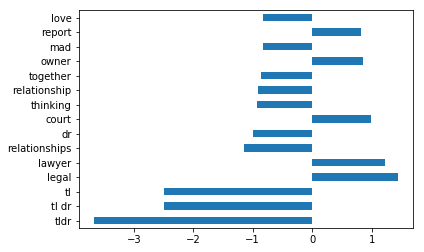

In [43]:
coef_df.sort_values('abs', ascending=False).head(15)[0].plot.barh();

## Multinomial Naive Bayes

[**return to top of notebook**](#Love-Problems-or-Law-Problems?)

In [44]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('mn_nb', MultinomialNB())
])

pipe_params = {
    'vectorizer__max_features':[100, 500],
    'vectorizer__stop_words':[None, stopwords.words('english')],
    'vectorizer__ngram_range':[(1,1), (1,2)]
}

gs = GridSearchCV(pipe,
                 pipe_params,
                 cv=5,
                 verbose=1)

In [45]:
%%time

gs.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.8min finished


CPU times: user 1min 48s, sys: 1.76 s, total: 1min 50s
Wall time: 1min 50s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), prepro...zer=None, vocabulary=None)), ('mn_nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vectorizer__max_features': [100, 500], 'vectorizer__stop_words': [None, ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'h...en', "weren't", 'won', "won't", 'wouldn', "wouldn't"]], 'vectorizer__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
    

In [46]:
gs_pipe_performance(gs, X_train, X_test, y_train, y_test)

Best score: 0.9390178089584458

Best params:
	vectorizer__max_features 500

	vectorizer__ngram_range (1, 2)

	vectorizer__stop_words ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'al

#### Confusion Matrix

,predicted relationship,predicted legal
actual relationship,595,22
actual legal,57,562


#### Performance Metrics

| Metric  | Score
|--------|--------------------
| Accuracy | 0.936 |
| Precision | 0.962 |
| Sensitivity | 0.908 |
| Specificity | 0.964 |
| Misclassification Rate | 0.064 |

## Conclusion

### In this case, judging by accuracy scores, the best model was a logistic regression, which performed better with an accuracy score of 97.3% whereas the multinomial naive Bayes had an accuracy score of 93.6%. The vectorizer that was used in the logistic regression model was CountVectorizer(), with parameters of `max_features`=500, `ngram_range`=(1,2), and `stop_words`=stopwords.words('english').

[**return to top of notebook**](#Love-Problems-or-Law-Problems?)